<a href="https://colab.research.google.com/github/christianb93/MLLM/blob/main/wiki/WikiTextTransformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#
# Import a few libraries that we need
#
import torch
import os
import argparse
from tqdm import tqdm
import json
import re
from torchtext.datasets import WikiText2
import requests
import time


In [2]:
#
# Install portalocker
#
#
# IMPORTANT: you might have to restart the runtime to allow Python to detect the library
#
!pip3 install portalocker

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#
# Download a few files from my GitHub repository that we will need
#
files = ["BPE.py", "util.py"]
URL = "https://raw.githubusercontent.com/christianb93/MLLM/main/wiki/"
for file in files:
    data = requests.get(URL+file)
    with open(file, 'wb')as f:
        f.write(data.content)
  
#
# and import them
# 
import BPE
import util

In [4]:
#
# Define a few constants
#
MERGES = 6000
VFILE= "vocab.dat"
RFILE = "rules.dat"
FULL_DATA = "data.json"
TRAIN_DATA = "train.json"
VAL_DATA = "val.json"

In [5]:
#
# Download WikiText2 dataset 
#
text = ""
print("Downloading WikiText2 data set")
ds = WikiText2(split="train")
items = [_p for _p in ds]
print("Cleaning data")
#
# Each item is a paragraph as a long string. Clean and concatenate
# 
for item in items:
    # Remove trailing whitespace and @
    item = re.sub("^\s+", "", item)
    item = re.sub("@", "", item)
    item = re.sub("\n", "", item)
    if not re.match("^=", item):
        text = text + item

#
# pretokenize to create a list of words
#
print("Pre-tokenizing text")
tokenizer = util.get_tokenizer()
pre_tokenized_text = tokenizer(text)
del text


Cleaning data
Pre-tokenizing text


In [6]:
encoder = BPE.BPEEncoder(progress_bars = True)
if not (os.path.exists(VFILE) and os.path.exists(RFILE)):
    print("Initializing vocabulary")
    encoder.init_vocab(pre_tokenized_text)
    print(f"Start BPE learning phase ({MERGES} merges)")
    encoder.learn(s = MERGES, align_vocab = True)
    encoder.save_rules(RFILE)
    encoder.save_vocab(VFILE)
else:
    print("Loading vocabulary and rules")
    encoder.load_rules(RFILE)
    encoder.load_vocab(VFILE)
print(f"Vocabulary size is now {len(encoder.get_vocab())}")


Initializing vocabulary
Counting words in input
Building word frequencies


Calculating frequencies: 100%|██████████| 33227/33227 [00:00<00:00, 668374.67it/s]


Start BPE learning phase (6000 merges)


Merging: 100%|██████████| 6034/6034 [01:34<00:00, 64.06it/s]

Vocabulary size is now 6400


In [7]:
#
# encode the input and save the results (or load from file)
#
if not os.path.exists(FULL_DATA):
    encoded_text = []
    encoder.compile_rules()
    for word in tqdm(pre_tokenized_text, desc="Encoding"):
        encoded_text.extend(encoder.encode(word))
    with open(FULL_DATA, "w") as f:
        json.dump(encoded_text, f) 
else:
    with open(FULL_DATA, "r") as f:
        encoded_text = json.load(f) 

del pre_tokenized_text


Encoding: 100%|██████████| 2007146/2007146 [04:00<00:00, 8350.52it/s] 


In [8]:
#
# split into a training and a validation set
#
total_length = len(encoded_text)
train_length = int(0.9*total_length)
print(f"Splitting file into {train_length} training items and {total_length - train_length} validation items")
with open(TRAIN_DATA, "w") as f:
    json.dump(encoded_text[:train_length], f) 
with open(VAL_DATA, "w") as f:
    json.dump(encoded_text[train_length:], f) 


Splitting file into 2360047 training items and 262228 validation items


In [9]:
#
# Training parameters
#
LR = 0.0005
DROPOUT = 0.2
BATCH_SIZE = 512
CONTEXT_SIZE = 48
#
# Create datasets for training and validation
#
train_ds = util.DataSet(window_size = CONTEXT_SIZE, encoder = None)
val_ds  = util.DataSet(window_size =CONTEXT_SIZE, data = "valid", encoder = train_ds.get_vocab())
print(f"Using data set with {len(train_ds)} training items and {len(val_ds)} validation items")

Using data set with 2359998 training items and 262179 validation items


In [10]:
#
# Create data loader. We drop the last batch to avoid spikes in the loss function, and we use two workers 
# which should be enough to keep most GPUs busy
#
training_data = torch.utils.data.DataLoader(train_ds, batch_size = BATCH_SIZE, collate_fn = util.collate_fn, shuffle = True, drop_last = True, num_workers = 2)
val_data = torch.utils.data.DataLoader(val_ds, batch_size = BATCH_SIZE, collate_fn = util.collate_fn, shuffle = True, drop_last = True)


In [11]:
#
# Our model
# 
MODEL_DIM = 192
FF_DIM = 1024
HEADS = 8
LAYERS = 4
DROPOUT = 0.2

#
# A layer that adds a positional embedding to a given input. We use a fixed
# sinusoidal embeddings as in the original "Attention is all you need" paper
#
class PosEmbeddingLayer(torch.nn.Module):
    
    def __init__(self, context_size, model_dim):
        super().__init__()
        _p = torch.arange(context_size , dtype=torch.float32).unsqueeze(dim = 1)
        _i = torch.arange(0, model_dim , step = 2) / model_dim 
        x = _p / torch.pow(10000, _i)
        self.register_buffer("_pe", torch.zeros(context_size, model_dim))        
        self._pe[:, 0::2] = torch.sin(x)
        self._pe[:, 1::2] = torch.cos(x)
        self._pe = torch.unsqueeze(self._pe, dim = 1)
        self._model_dim = model_dim
        self._context_size = context_size
        
    #
    # Shape of input: (sequence length, batch_size, model_dim) 
    #
    def forward(self, x):
        assert len(x.shape) == 3, "Shape (L, B, D) required"
        assert x.shape[2] == self._model_dim, "Last dimension needs to be model dimension"
        L = x.shape[0]
        assert L <= self._context_size, "Length exceeds context size"
        pe = self._pe[:L, :, :]
        return x + pe

#
# A simple decoder-only transformer model, with a learned
# word embedding, a sinusoidal positional embedding and a linear
# output layer
#
class Model(torch.nn.Module):
    
    def __init__(self, vocab_size, model_dim = MODEL_DIM, context_size = CONTEXT_SIZE, ff_dim = FF_DIM, heads = HEADS, layers = LAYERS, dropout = DROPOUT):
        super().__init__()
        self._word_embedding = torch.nn.Embedding(vocab_size, model_dim)
        self._pe_embedding = PosEmbeddingLayer(context_size, model_dim)
        layer = torch.nn.TransformerEncoderLayer(d_model = model_dim, nhead = heads, dim_feedforward = ff_dim, dropout = dropout)
        self._transformer = torch.nn.TransformerEncoder(layer, num_layers = layers)
        self._linear = torch.nn.Linear(in_features = model_dim, out_features = vocab_size)
        self._model_dim = model_dim
        self._context_size = context_size
        self._vocab_size = vocab_size
        cached_mask = torch.tril(torch.ones(context_size, context_size)*(-1)*float('inf'), diagonal = -1).t()
        self.register_buffer("_cached_mask", cached_mask)
    
    #
    # Create a causal self-attention mask
    #
    def get_self_attention_mask(self):
        return self._cached_mask
        
    #
    # Shape of input: (L, B)
    # 
    def forward(self, x):
        assert len(x.shape) == 2, "Expecting two-dimensional input"
        (L, B) = x.shape
        x = self._word_embedding(x) # shape (L, B, model_dim)
        x = self._pe_embedding(x) 
        #
        # Mask input. As we have registered this is a buffer, it
        # should already be on the same device as the model
        #
        mask = self.get_self_attention_mask()[:L, :L]
        x = self._transformer(x, mask = mask)
        return self._linear(x)        

    #
    # Get context size
    #
    def get_context_size(self):
        return self._context_size



In [12]:
V = len(train_ds.get_vocab())
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(vocab_size = V, model_dim = MODEL_DIM, context_size = CONTEXT_SIZE,  dropout = DROPOUT).to(device)
model.train()

Model(
  (_word_embedding): Embedding(6400, 192)
  (_pe_embedding): PosEmbeddingLayer()
  (_transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=192, out_features=192, bias=True)
        )
        (linear1): Linear(in_features=192, out_features=1024, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=1024, out_features=192, bias=True)
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (_linear): Linear(in_features=192, out_features=6400, bias=True)
)

In [13]:
EPOCHS = 3
print(f"Training for {EPOCHS} epochs")
print(f"Using device {device} and batch size {BATCH_SIZE}, lr = {LR} (min {LR*0.1}), dropout = {DROPOUT}")
start_time = time.time()
torch.set_float32_matmul_precision('high')
losses, val_losses = util.train(model, EPOCHS, batch_size = BATCH_SIZE,
               train_data_loader = training_data, val_data_loader = val_data, 
               device = device, log_steps = 250, 
               lr = LR, lr_min = LR*0.1, autocast = True)
end_time = time.time()
print(f"Total training time: {end_time - start_time}")


Training for 3 epochs
Using device cuda and batch size 512, lr = 0.0005 (min 5e-05), dropout = 0.2
Steps per epoch: 4609


Epoch 0:   5%|▌         | 251/4609 [00:29<07:59,  9.08it/s]

Completed 250 steps (0.117 seconds per step), current loss is 6.037606716156006


Epoch 0:  11%|█         | 501/4609 [00:57<07:46,  8.81it/s]

Completed 500 steps (0.112 seconds per step), current loss is 5.241933345794678


Epoch 0:  16%|█▋        | 751/4609 [01:26<07:39,  8.40it/s]

Completed 750 steps (0.116 seconds per step), current loss is 4.964645862579346


Epoch 0:  22%|██▏       | 1001/4609 [01:55<06:53,  8.72it/s]

Completed 1000 steps (0.117 seconds per step), current loss is 4.779524326324463


Epoch 0:  27%|██▋       | 1251/4609 [02:24<06:18,  8.87it/s]

Completed 1250 steps (0.115 seconds per step), current loss is 4.606695652008057


Epoch 0:  33%|███▎      | 1501/4609 [02:53<05:55,  8.74it/s]

Completed 1500 steps (0.115 seconds per step), current loss is 4.497130393981934


Epoch 0:  38%|███▊      | 1751/4609 [03:22<05:43,  8.33it/s]

Completed 1750 steps (0.116 seconds per step), current loss is 4.441714763641357


Epoch 0:  43%|████▎     | 2001/4609 [03:50<04:53,  8.87it/s]

Completed 2000 steps (0.113 seconds per step), current loss is 4.370137691497803


Epoch 0:  49%|████▉     | 2251/4609 [04:19<04:25,  8.88it/s]

Completed 2250 steps (0.113 seconds per step), current loss is 4.298154830932617


Epoch 0:  54%|█████▍    | 2501/4609 [04:47<04:02,  8.70it/s]

Completed 2500 steps (0.113 seconds per step), current loss is 4.228367328643799


Epoch 0:  60%|█████▉    | 2751/4609 [05:15<03:36,  8.59it/s]

Completed 2750 steps (0.114 seconds per step), current loss is 4.217047691345215


Epoch 0:  65%|██████▌   | 3001/4609 [05:44<03:02,  8.83it/s]

Completed 3000 steps (0.114 seconds per step), current loss is 4.180335998535156


Epoch 0:  71%|███████   | 3251/4609 [06:12<02:33,  8.87it/s]

Completed 3250 steps (0.113 seconds per step), current loss is 4.125865459442139


Epoch 0:  76%|███████▌  | 3501/4609 [06:41<02:04,  8.87it/s]

Completed 3500 steps (0.115 seconds per step), current loss is 4.051138401031494


Epoch 0:  81%|████████▏ | 3751/4609 [07:09<01:41,  8.46it/s]

Completed 3750 steps (0.114 seconds per step), current loss is 4.076267719268799


Epoch 0:  87%|████████▋ | 4001/4609 [07:38<01:08,  8.89it/s]

Completed 4000 steps (0.114 seconds per step), current loss is 4.061057090759277


Epoch 0:  92%|█████████▏| 4251/4609 [08:06<00:40,  8.86it/s]

Completed 4250 steps (0.113 seconds per step), current loss is 3.9958536624908447


Epoch 0:  98%|█████████▊| 4501/4609 [08:35<00:12,  8.82it/s]

Completed 4500 steps (0.115 seconds per step), current loss is 3.9946582317352295


Epoch 0: 100%|██████████| 4609/4609 [08:47<00:00,  8.73it/s]


Completed epoch 0, validation loss is 4.8175, duration 570.89 seconds, current learning rate is 0.000390
Saved model checkpoint at model_0.pt


Epoch 1:   3%|▎         | 142/4609 [00:16<08:24,  8.86it/s]

Completed 4750 steps (0.290 seconds per step), current loss is 4.021607398986816


Epoch 1:   9%|▊         | 392/4609 [00:45<07:51,  8.94it/s]

Completed 5000 steps (0.114 seconds per step), current loss is 3.9419784545898438


Epoch 1:  14%|█▍        | 642/4609 [01:13<07:58,  8.29it/s]

Completed 5250 steps (0.114 seconds per step), current loss is 3.921334981918335


Epoch 1:  19%|█▉        | 892/4609 [01:42<06:55,  8.94it/s]

Completed 5500 steps (0.116 seconds per step), current loss is 3.9249675273895264


Epoch 1:  25%|██▍       | 1142/4609 [02:11<06:29,  8.91it/s]

Completed 5750 steps (0.114 seconds per step), current loss is 3.914746046066284


Epoch 1:  30%|███       | 1392/4609 [02:39<06:02,  8.88it/s]

Completed 6000 steps (0.114 seconds per step), current loss is 3.9185609817504883


Epoch 1:  36%|███▌      | 1642/4609 [03:08<05:58,  8.28it/s]

Completed 6250 steps (0.116 seconds per step), current loss is 3.869535207748413


Epoch 1:  41%|████      | 1892/4609 [03:37<05:11,  8.74it/s]

Completed 6500 steps (0.114 seconds per step), current loss is 3.870013952255249


Epoch 1:  46%|████▋     | 2142/4609 [04:05<04:38,  8.85it/s]

Completed 6750 steps (0.115 seconds per step), current loss is 3.90073561668396


Epoch 1:  52%|█████▏    | 2392/4609 [04:34<04:10,  8.86it/s]

Completed 7000 steps (0.116 seconds per step), current loss is 3.8645694255828857


Epoch 1:  57%|█████▋    | 2642/4609 [05:04<04:02,  8.10it/s]

Completed 7250 steps (0.116 seconds per step), current loss is 3.814094305038452


Epoch 1:  63%|██████▎   | 2892/4609 [05:33<03:14,  8.84it/s]

Completed 7500 steps (0.119 seconds per step), current loss is 3.865384340286255


Epoch 1:  68%|██████▊   | 3142/4609 [06:02<02:53,  8.47it/s]

Completed 7750 steps (0.115 seconds per step), current loss is 3.831814765930176


Epoch 1:  74%|███████▎  | 3392/4609 [06:31<02:17,  8.82it/s]

Completed 8000 steps (0.116 seconds per step), current loss is 3.7883388996124268


Epoch 1:  79%|███████▉  | 3642/4609 [07:00<01:48,  8.94it/s]

Completed 8250 steps (0.115 seconds per step), current loss is 3.8557214736938477


Epoch 1:  84%|████████▍ | 3892/4609 [07:29<01:24,  8.44it/s]

Completed 8500 steps (0.117 seconds per step), current loss is 3.7882261276245117


Epoch 1:  90%|████████▉ | 4142/4609 [07:58<00:53,  8.80it/s]

Completed 8750 steps (0.115 seconds per step), current loss is 3.806849718093872


Epoch 1:  95%|█████████▌| 4392/4609 [08:27<00:25,  8.58it/s]

Completed 9000 steps (0.115 seconds per step), current loss is 3.7906405925750732


Epoch 1: 100%|██████████| 4609/4609 [08:53<00:00,  8.65it/s]


Completed epoch 1, validation loss is 4.8115, duration 576.60 seconds, current learning rate is 0.000164
Saved model checkpoint at model_1.pt


Epoch 2:   1%|          | 33/4609 [00:04<09:02,  8.43it/s]

Completed 9250 steps (0.295 seconds per step), current loss is 3.764889717102051


Epoch 2:   6%|▌         | 283/4609 [00:33<08:10,  8.82it/s]

Completed 9500 steps (0.116 seconds per step), current loss is 3.7943499088287354


Epoch 2:  12%|█▏        | 533/4609 [01:01<07:38,  8.89it/s]

Completed 9750 steps (0.113 seconds per step), current loss is 3.7868385314941406


Epoch 2:  17%|█▋        | 783/4609 [01:30<07:20,  8.69it/s]

Completed 10000 steps (0.114 seconds per step), current loss is 3.776592493057251


Epoch 2:  22%|██▏       | 1033/4609 [01:58<06:41,  8.91it/s]

Completed 10250 steps (0.114 seconds per step), current loss is 3.7608869075775146


Epoch 2:  28%|██▊       | 1283/4609 [02:27<06:15,  8.85it/s]

Completed 10500 steps (0.114 seconds per step), current loss is 3.768221616744995


Epoch 2:  33%|███▎      | 1533/4609 [02:56<05:51,  8.75it/s]

Completed 10750 steps (0.116 seconds per step), current loss is 3.7297658920288086


Epoch 2:  39%|███▊      | 1783/4609 [03:25<05:18,  8.87it/s]

Completed 11000 steps (0.115 seconds per step), current loss is 3.7596170902252197


Epoch 2:  44%|████▍     | 2033/4609 [03:53<04:54,  8.76it/s]

Completed 11250 steps (0.115 seconds per step), current loss is 3.7774746417999268


Epoch 2:  50%|████▉     | 2283/4609 [04:22<04:30,  8.60it/s]

Completed 11500 steps (0.116 seconds per step), current loss is 3.733886480331421


Epoch 2:  55%|█████▍    | 2533/4609 [04:51<03:54,  8.85it/s]

Completed 11750 steps (0.115 seconds per step), current loss is 3.755983352661133


Epoch 2:  60%|██████    | 2783/4609 [05:20<03:35,  8.47it/s]

Completed 12000 steps (0.116 seconds per step), current loss is 3.7482786178588867


Epoch 2:  66%|██████▌   | 3033/4609 [05:49<03:00,  8.73it/s]

Completed 12250 steps (0.116 seconds per step), current loss is 3.7699458599090576


Epoch 2:  71%|███████   | 3283/4609 [06:18<02:31,  8.78it/s]

Completed 12500 steps (0.116 seconds per step), current loss is 3.7269277572631836


Epoch 2:  77%|███████▋  | 3533/4609 [06:47<02:03,  8.72it/s]

Completed 12750 steps (0.116 seconds per step), current loss is 3.7200326919555664


Epoch 2:  82%|████████▏ | 3783/4609 [07:16<01:38,  8.38it/s]

Completed 13000 steps (0.116 seconds per step), current loss is 3.7289021015167236


Epoch 2:  88%|████████▊ | 4033/4609 [07:45<01:06,  8.67it/s]

Completed 13250 steps (0.116 seconds per step), current loss is 3.759183645248413


Epoch 2:  93%|█████████▎| 4283/4609 [08:13<00:37,  8.68it/s]

Completed 13500 steps (0.115 seconds per step), current loss is 3.7053349018096924


Epoch 2:  98%|█████████▊| 4533/4609 [08:42<00:08,  8.59it/s]

Completed 13750 steps (0.116 seconds per step), current loss is 3.758755922317505


Epoch 2: 100%|██████████| 4609/4609 [08:52<00:00,  8.66it/s]


Completed epoch 2, validation loss is 4.8143, duration 575.48 seconds, current learning rate is 0.000050
Saved model checkpoint at model_2.pt
Total training time: 1723.1558029651642


Epoch 0 ---> validation loss 4.8175
Epoch 1 ---> validation loss 4.8115
Epoch 2 ---> validation loss 4.8143


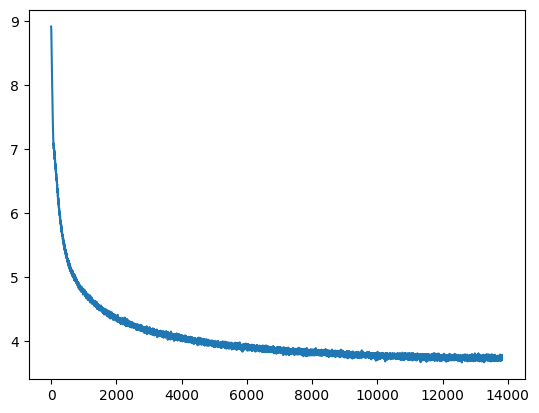

In [14]:
import matplotlib.pyplot as plt
plt.plot(losses) 
for epoch, loss in enumerate(val_losses):
    print(f"Epoch {epoch} ---> validation loss {loss:.4f}")


In [15]:
#
# Sample using nucleus sampling
#
def predict(prompt = ". ", length = 200, temperature = 0.7):
    sample_ids = util.do_sample(prompt, model, encoder, device = device, method = 3, length = length, temperature = temperature)
    sample = util.beautify_decoder_output(encoder.decode(sample_ids))
    #
    # Strip off prompt again if we have used the default prompt
    #
    if prompt == ". ":
        sample = sample[len(prompt):]

    return sample



In [16]:
sample = predict()

from IPython.display import display, Markdown
display(Markdown(f"{sample}"))

For the time, the actors of the <unk> 's first minister. The people involved in the commune with a second verse, including <unk>, a <unk> and a <unk>, <unk>, which has to <unk> <unk> and to help him a <unk>. He ended his claim to his parties, and was an English was the most memory of the year. He is a supporter and thus fever in his own life. He was a second son of Bobby Hall of Fame, and played as a member of the leadership in the Japanese role of the Garden Fill. Federer also received the first title of the Australian Open in the finals, including the Madonna Open, the Duke of Florence, and his first tournament. Federer won the final, losing to the finals, having scored a record nine times to five consecutive weeks before losing 19, in the Bir 'Shoot <unk>, an injury. Bellers were <unk>, they were defeated 